# Tokyo Housing Database & Price Forecasting

> *This project analyzes Tokyo’s rental housing landscape to support strategic decisions at Student Mobilization, Inc. The process involves scraping over 1,000 listings from SUUMO.jp, storing and organizing the data in an SQLite database, and applying regression models to forecast rental prices based on features such as floor plan, area, and building age. The goal is to streamline housing logistics for new field staff by simplifying the search for affordable and well-located housing options.*
>
> **Key Questions**
> - Can we predict rental prices based on key features?
> - How does proximity to train stations influence prices?
> - What numerical features are most correlated with rent?
> - What is the 95% confidence interval for the mean rental price?
> - Are new buildings consistently priced higher than old ones?

In [1]:
#Install the 'ipython-sql' and 'prettytable' libraries using pip
!pip install ipython-sql prettytable

# Import necessary Python modules for web scraping, SQLite, data analysis, and regression modeling
import requests, json, sqlite3, sys, re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import prettytable 
from bs4 import BeautifulSoup
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats
from matplotlib import font_manager, rc
from sklearn.preprocessing import OneHotEncoder
import warnings
from scipy.stats import norm
prettytable.DEFAULT = 'DEFAULT'

# Load SQL magic extension to run SQL queries directly in notebook cells
%load_ext sql

## Housing Data Collection & Preparation

>In this section, we build an **object-oriented pipeline** to:  
>1. **Collect raw HTML** from *SUUMO.jp*.  
>2. **Transform the HTML** into structured, readable data and housing metrics.  
>3. **Store the processed data** in an SQLite database.

In [10]:
# Path to the SQLite database where scraped housing data will be stored
db = 'tokyo_housing.db'

# Base URL of Suumo (Japanese housing site)
base_url = 'https://suumo.jp/'

# URLs for initial listings pages 
starting_url = 'https://suumo.jp/jj/chintai/ichiran/FR301FC001/?url=%2Fchintai%2Fichiran%2FFR301FC001%2F&ar=030&bs=040&pc=50&smk=&po1=25&po2=99&shkr1=03&shkr2=03&shkr3=03&shkr4=03&cb=0.0&ct=25.0&md=01&md=02&md=03&md=04&md=05&md=06&md=07&md=08&md=09&md=10&et=20&mb=0&mt=9999999&cn=9999999&ra=013&ek=035017990&ek=035026830&rn=0350&ae=03501'

### Data Collection Class: `TokyoHousingScraper`
> This class handles all **data ingestion** tasks, including:
> - Initializing local SQLite database connection
> - Scraping Tokyo listings HTML from *SUUMO.jp*
> - Parsing station information and other housing metrics from raw HTML
> - Building a robust housing dataset which includes features such as: `title`, `floor`, `area`, `rent`, `deposit`, etc.
> - Storing the resulting dataset in local SQLite table

In [11]:
# Define TokyoHousingScraper to:
# - Scrape Tokyo housing listings from Suumo.jp
# - Collect listings, parse property details
# - Store the results in SQLite database

class TokyoHousingScraper:
    def __init__(self, db, base_url, url):
        # Initialize DB connection
        self.db = db
        self.conn = sqlite3.connect(self.db)
        self.cursor = self.conn.cursor()
        
        # Base URL and starting page
        self.base_url = base_url
        self.url = url
    
    def scrape_listings(self):
	    # Define list for storing HTML
        self.listings = list()
	    
	    # Iterate through all pages of listings
        while True:
            try:
                response = requests.get(next_page) #this will only work after the first page
            except:
                response = requests.get(self.url) # starting url 
            soup = BeautifulSoup(response.text, 'lxml')
		    
		    # Each listing = cassetteitem div
            cassettes = soup.select('div.cassetteitem')
            self.listings.extend(cassettes)
            #print(len(self.listings))
            
		    # Find next page link (pagination)
            try:
                current_page = soup.find('li', class_ = 'pagination-current')
                next_page_path = current_page.find_next_siblings('li')[1]
                next_page = self.base_url + next_page_path.select_one('a').get('href')
            except: break #no more pages to comb through
            
        print(f'{len(self.listings)} listings were successfully gathered!')
        
    def parse_station_info(self, item):
    	
        # Extract station information (names, distances, nearest, average).
        # Returns tuple: 
            # (stations_str, nearest_station, distance_to_nearest_station, avg_distance).
        
	    # Get raw station blocks
        stations_list = item.select('li.cassetteitem_detail-col2 div.cassetteitem_detail-text'
	    ) if item.select(
		    'li.cassetteitem_detail-col2 div.cassetteitem_detail-text'
	    ) else None
        
	    # If there is no station information, return None
        if stations_list == None:
            return (None, None, None, None)
        else: pass
        
	    # Remove empty tags
        stations_list = [s for s in stations_list if s != '']
        
	    # All stations as a single string (for DB storage)
        self.stations_str = ",".join([station.get_text().strip() for station in stations_list])
        
	    # Extract stations and distances with regex
        stations_dict = {
		    # All listed stations
		    'stations': [
			    re.findall(r'/(?P<station>.*?)\s*歩', station.get_text().strip())[0] 
			    for station in stations_list
			    if re.findall(r'/(?P<station>.*?)\s*歩', station.get_text().strip())
		    ],
            
		    'distances': [
			    re.findall(r'\d+', station.get_text().strip())[0]
			    for station in stations_list
			    if re.findall(r'\d+', station.get_text().strip())
		    ]
	    }
        
	    # Compute distance to nearest station
        self.distance_to_nearest_station = min([int(dist) for dist in stations_dict['distances']])
        nearest_idx = stations_dict['distances'].index(str(self.distance_to_nearest_station))
        self.nearest_station = stations_dict['stations'][nearest_idx]
        
	    # Compute average distance to surrounding stations
        self.avg_distance = np.mean([float(dist) for dist in stations_dict['distances']])
        
        return self.stations_str, self.nearest_station, self.distance_to_nearest_station, self.avg_distance
        
    def build_housing_dataset(self):
    	
	    # Extract housing data (title, rent, floor, area, stations, etc.)
            # and save into SQLite as a DataFrame.
        
        self.housing_data = [
	    {
		    'img': item.select_one(
                'div.cassetteitem_object img'
            ).get('rel') if item.select_one(
                'div.cassetteitem_object img'
            ) else None,
            
            'title': item.select_one(
			    'div.cassetteitem_content-title'
		    ).get_text().strip() if item.select_one(
			    'div.cassetteitem_content-title'
		    ) else None,
            
		    'address': item.select_one(
			    'li.cassetteitem_detail-col1'
		    ).get_text().strip() if item.select_one(
			    'li.cassetteitem_detail-col1'
		    ) else None,
            
		    'rent': item.select_one(
			    'span.cassetteitem_price.cassetteitem_price--rent'
		    ).get_text().strip() if item.select_one(
			    'div.cassetteitem-item span.cassetteitem_price.cassetteitem_price--rent'
		    ) else None,
            
		    'management_fee': item.select_one(
			    'span.cassetteitem_price.cassetteitem_price--administration'
		    ).get_text().strip() if item.select_one(
			    'span.cassetteitem_price.cassetteitem_price--administration'
		    ) else None,
            
		    'deposit': item.select_one(
			    'span.cassetteitem_price.cassetteitem_price--deposit'
		    ).get_text().strip() if item.select_one(
    		    'span.cassetteitem_price.cassetteitem_price--deposit'
		    ) else None,
            
		    'key_money': item.select_one(
			    'span.cassetteitem_price.cassetteitem_price--gratuity'
		    ).get_text().strip() if item.select_one(
			    'span.cassetteitem_price.cassetteitem_price--gratuity'
		    ) else None,
            
		    'floor': item.select(
			    'div.cassetteitem-item tr.js-cassette_link td'
		    )[2].get_text().strip() if item.select(
			    'div.cassetteitem-item tr.js-cassette_link td'
		    )[2] else None,
            
		    'floor_plan': item.select_one(
			    'span.cassetteitem_madori'
		    ).get_text().strip() if item.select_one(
			    'span.cassetteitem_madori'
		    ) else None,
            
		    'area': item.select_one(
			    'span.cassetteitem_menseki'
		    ).get_text().strip() if item.select_one(
			    'span.cassetteitem_menseki'
		    ) else None,
            
		    'building_age': item.select(
			    'li.cassetteitem_detail-col3 div'
		    )[0].get_text().strip() if item.select(
			    'li.cassetteitem_detail-col3'
		    ) else None,
            
		    'building_size': item.select(
			    'li.cassetteitem_detail-col3 div'
		    )[1].get_text().strip() if item.select(
			    'li.cassetteitem_detail-col3'
		    ) else None,
            
		    'stations': self.parse_station_info(item)[0],
            
		    'nearest_station': self.parse_station_info(item)[1],
            
		    'distance_to_nearest_station': self.parse_station_info(item)[2],
            
		    'avg_distance_to_stations': self.parse_station_info(item)[3]
	    }
		    for item in self.listings
	    ]
        
	    # Save to DataFrame + SQLite
        self.housing_data_df = pd.DataFrame(self.housing_data)
        self.housing_data_df.to_sql(name = 'HOUSING_DATA', con = self.conn, if_exists = 'replace', index = False)
        
	    # Close the DB connection
        self.conn.close()

### Initialize Scraper & Gather Data
>In this section, we **initialize the TokyoHousingScraper**, **scrape rental listings**, and **build a structured housing dataset** stored in SQLite.

In [ ]:
# Initialize scraper
scraper = TokyoHousingScraper(db, base_url, starting_url)

# Scrape housing listings
scraper.scrape_listings()

# Parse listing details and save dataset to SQLite
scraper.build_housing_dataset()

## Extracting & Engineering Tokyo Housing Metrics 
>- Connect to local SQLite database `db` containing listing information and housing metrics.
>- Initialize SQL Magic (`%sql`) to run queries directly from the notebook. 

In [18]:
# Connect to SQLite database for querying listings 
conn = sqlite3.connect(db)
cursor = conn.cursor()

# Initialize SQL Magic with database connection
%sql sqlite:///tokyo_housing.db

### Create SQL View

>**Step 1: Standardize core listing fields**  
>- `img`, `title`, `address`: Basic identifiers  
>- `rent`, `management_fee`, `deposit`, `key_money`: Convert to numeric values  
>- `floor`: Convert floor labels to integers  
>- `floor_plan`: Normalize labels (e.g., 'ワンルーム' → '1R')  
>- `area`: Convert to numeric (square meters)  
>- `building_age`: Extract age in years  
>- `building_size`: Standardize number of floors  
>- `stations`, `nearest_station`, `distance_to_nearest_station`, `avg_distance_to_stations`: Station-related features  
>
>**Step 2: Handle missing or invalid values**  
>- Replace 0 or invalid values in `management_fee`, `deposit`, `key_money` with NULL  
>
>**Step 3: Feature engineering**  
>- `avg_rent_by_station`: Average rent per nearest station  
>- `avg_rent_by_floor_plan`: Average rent per floor plan  
>- `price_rank_by_station`: Rank rent relative to other listings near the same station  
>
>**Step 4: Build final view**  
>- Combine standardized fields and engineered features into `FEATURED_LISTINGS`  
>- Output all listings in `TOKYO_HOUSING` view

In [ ]:
%%sql 
-- Remove the view if it already exists
DROP VIEW IF EXISTS TOKYO_HOUSING;

-- Create a cleaned + feature-engineered housing view
CREATE VIEW TOKYO_HOUSING AS

WITH STANDARDIZED_LISTINGS AS (
    SELECT 
        -- Basic identifiers
        img, title, address, 
        
        -- Convert rent/deposit/key money into numeric
        CAST(RTRIM(rent, '万円') AS FLOAT) * 10000 AS rent,
        CAST(RTRIM(management_fee, '円') AS INTEGER) AS management_fee,
        CAST(RTRIM(deposit, '万円') AS FLOAT) * 10000 AS deposit,
        CAST(RTRIM(key_money, '万円') AS FLOAT) * 10000 AS key_money,
        
        -- Convert floor to integer
        CAST(RTRIM(floor, '階') AS INTEGER) AS floor,
        
        -- Normalize floor plan labels 
        CASE
            WHEN floor_plan = 'ワンルーム' THEN '1R'
            ELSE floor_plan
        END AS floor_plan,
        
        -- Convert area to numeric (square meters)
        CAST(RTRIM(area, 'm2') AS FLOAT) AS area,
        
        -- Extract building age in years
        CAST(LTRIM(RTRIM(building_age, '年'), '築') AS INTEGER) AS building_age,
        
        -- Standardize building size
        CASE
            WHEN building_size LIKE '地下%' THEN 
                CAST(SUBSTR(building_size, 3, 1) AS INTEGER) +
                CAST(SUBSTR(building_size, 6, 1) AS INTEGER)
            WHEN building_size LIKE '地上%' THEN
                CAST(SUBSTR(building_size, 3, 1) AS INTEGER)
            ELSE CAST(RTRIM(building_size, '階建') AS INTEGER)
        END AS building_size,
        
        -- Station-related features
        stations,
        nearest_station,
        distance_to_nearest_station,
        ROUND(avg_distance_to_stations, 2) AS avg_distance_to_stations
    FROM HOUSING_DATA
),

FEATURED_LISTINGS AS (
    SELECT 
        img, title, address, rent, 
        
        -- Replace 0/invalid values with NULLs
        NULLIF(management_fee, 0) AS management_fee,
        NULLIF(deposit, -0.0) AS deposit,
        NULLIF(key_money, 0.0) AS key_money,
        floor, floor_plan, area, building_age,
        building_size, nearest_station,
        distance_to_nearest_station, avg_distance_to_stations,
        
        -- Feature engineering: average rents by station, floor plan, and distance to nearest station
        ROUND(AVG(rent) 
            OVER (PARTITION BY nearest_station), 2) 
            AS avg_rent_by_station, 
        ROUND(AVG(rent)
            OVER (PARTITION BY floor_plan), 2) 
            AS avg_rent_by_floor_plan,
        
        -- Price rank relative to other listings near the same station
        DENSE_RANK() 
            OVER (PARTITION BY nearest_station ORDER BY rent DESC)
            AS price_rank_by_station
    FROM STANDARDIZED_LISTINGS
)

-- Final output 
SELECT * FROM FEATURED_LISTINGS

### Load SQL View Into DataFrame
>- Use `%sql` to query `TOKYO_HOUSING` and convert results to a Dataframe for further analysis.
>- Once data is in pandas, we close the database connection. 

In [ ]:
# Query the engineered SQL view into a pandas DataFrame for analysis
tokyo_housing = %sql SELECT * FROM TOKYO_HOUSING 
tokyo_housing_df = tokyo_housing.DataFrame()

# Close the DB connection 
conn.close()

## Data Cleaning & Overview
>- Display the DataFrame structure, column data types, and non-null counts.
>- Generate summary statistics for both numeric and categorical columns.
>- Drop duplicate rows. 

In [16]:
# Drop duplicate listings 
tokyo_housing_df.drop_duplicates(inplace = True)

In [3]:
tokyo_housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   img                          1202 non-null   object 
 1   title                        1207 non-null   object 
 2   address                      1207 non-null   object 
 3   rent                         1207 non-null   float64
 4   management_fee               1034 non-null   float64
 5   deposit                      825 non-null    float64
 6   key_money                    788 non-null    float64
 7   floor                        1207 non-null   int64  
 8   floor_plan                   1207 non-null   object 
 9   area                         1207 non-null   float64
 10  building_age                 1207 non-null   int64  
 11  building_size                1207 non-null   int64  
 12  nearest_station              1207 non-null   object 
 13  distance_to_neares

In [4]:
tokyo_housing_df.describe(include = 'all')

,img,title,address,rent,management_fee,deposit,key_money,floor,floor_plan,area,building_age,building_size,nearest_station,distance_to_nearest_station,avg_distance_to_stations,avg_rent_by_station,avg_rent_by_floor_plan,price_rank_by_station
count,1202,1207,1207,1207.000000,1034.000000,825.000000,788.000000,1207.000000,1207,1207.000000,1207.000000,1207.000000,1207,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000
unique,1202,1156,45,NaN,NaN,NaN,NaN,NaN,15,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN
top,https://img01.suumo.com/front/gazo/fr/bukken/4...,ＪＲ山手線 高田馬場駅 4階建 築3年,東京都新宿区高田馬場３,NaN,NaN,NaN,NaN,NaN,1K,NaN,NaN,NaN,中井駅,NaN,NaN,NaN,NaN,NaN
freq,1,4,100,NaN,NaN,NaN,NaN,NaN,517,NaN,NaN,NaN,235,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,101696.520298,6964.119923,106328.121212,115307.233503,2.717481,NaN,26.720017,22.607291,4.649544,NaN,5.353770,9.407026,101620.114391,101677.018028,43.293289
std,NaN,NaN,NaN,42696.128135,4196.799459,59970.635488,64419.889365,2.200682,NaN,13.045711,15.697647,3.054339,NaN,2.520552,2.298308,7978.506092,34782.337937,24.968109
min,NaN,NaN,NaN,30000.000000,200.000000,30000.000000,30000.000000,0.000000,NaN,0.000000,0.000000,1.000000,NaN,1.000000,2.000000,85730.770000,63000.000000,1.000000
25%,NaN,NaN,NaN,69000.000000,3000.000000,69000.000000,74000.000000,1.000000,NaN,19.030000,9.000000,2.000000,NaN,3.000000,7.670000,97854.650000,74262.690000,22.000000
50%,NaN,NaN,NaN,89000.000000,6000.000000,87000.000000,94000.000000,2.000000,NaN,24.610000,21.000000,4.000000,NaN,5.000000,9.670000,104994.060000,87425.190000,43.000000
75%,NaN,NaN,NaN,125000.000000,10000.000000,125000.000000,138000.000000,3.000000,NaN,31.050000,35.000000,6.000000,NaN,7.000000,11.000000,106420.470000,108070.420000,63.000000


## Exploring Patterns & Insights from Tokyo Rentals
> In this section, we perform **exploratory data analysis (EDA)** to uncover patterns, relationships, and potential drivers of rental prices. The analysis evaluates a range of features including area, building age, building size, floor plan, and station proximity to **better understand how different factors influence pricing**.

### Correlation Analysis of Housing Features
>To identify relationships between numeric features, we computed a **correlation matrix** and visualized it with a **heatmap**. This helps highlight **which variables are strongly associated with each other** and may influence rent.

In [ ]:
# Compute correlation matrix for all numeric features
housing_corr = tokyo_housing_df.select_dtypes(['int64', 'float64']).corr()

# Initialize figure
fig = plt.figure(figsize = (15, 8))

# Plot heatmap of correlations
sns.heatmap(data = housing_corr, cmap = 'vlag', annot = True, linecolor = 'black', linewidths = 0.5, fmt = '.2f', cbar_kws = {'label': 'Correlation Coefficient'})

# Set figure title
fig.suptitle('Correlation Heatmap of Housing Metrics', fontweight = 'bold', fontsize = 18)

plt.tight_layout()
plt.savefig('correlation.png')

>Since there are many features and corresponding correlation coefficients, we won’t discuss each individually. For this analysis, we focus on the features most relevant to our objectives. In particular, **we are only concerned with the relationships between** `rent` **and other features**.
>- `management_fee`, `deposit`, `key_money`: As expected, these features show **strong correlations with** `rent`. It is also reasonable to assume that there exists **strong multicolinearty** among them. Therefore, we **will not explore these features** further in relation to `rent`.
>- `floor`, `building_age`, `building_size`: These features show **moderate correlations with** `rent`. Specifically, `floor` and `building_size` are positively correlated with `rent`, while `building_age` is negatively correlated. In other words, **larger buildings and units on higher floors tend to be more expensive**, whereas **older buildings generally have lower rents**.
>- `area`: This feature exhibits the **strongest correlation with** `rent` **among all variables**. In other words, the **size** of a housing unit is the **most influential factor in determining its rental price**.
>- `distance_to_nearest_station`, `avg_distance_to_stations`: These features show **little to no correlation with** `rent`. This finding is somewhat surprising given a prior assumption that proximity to nearby stations would influence pricing.

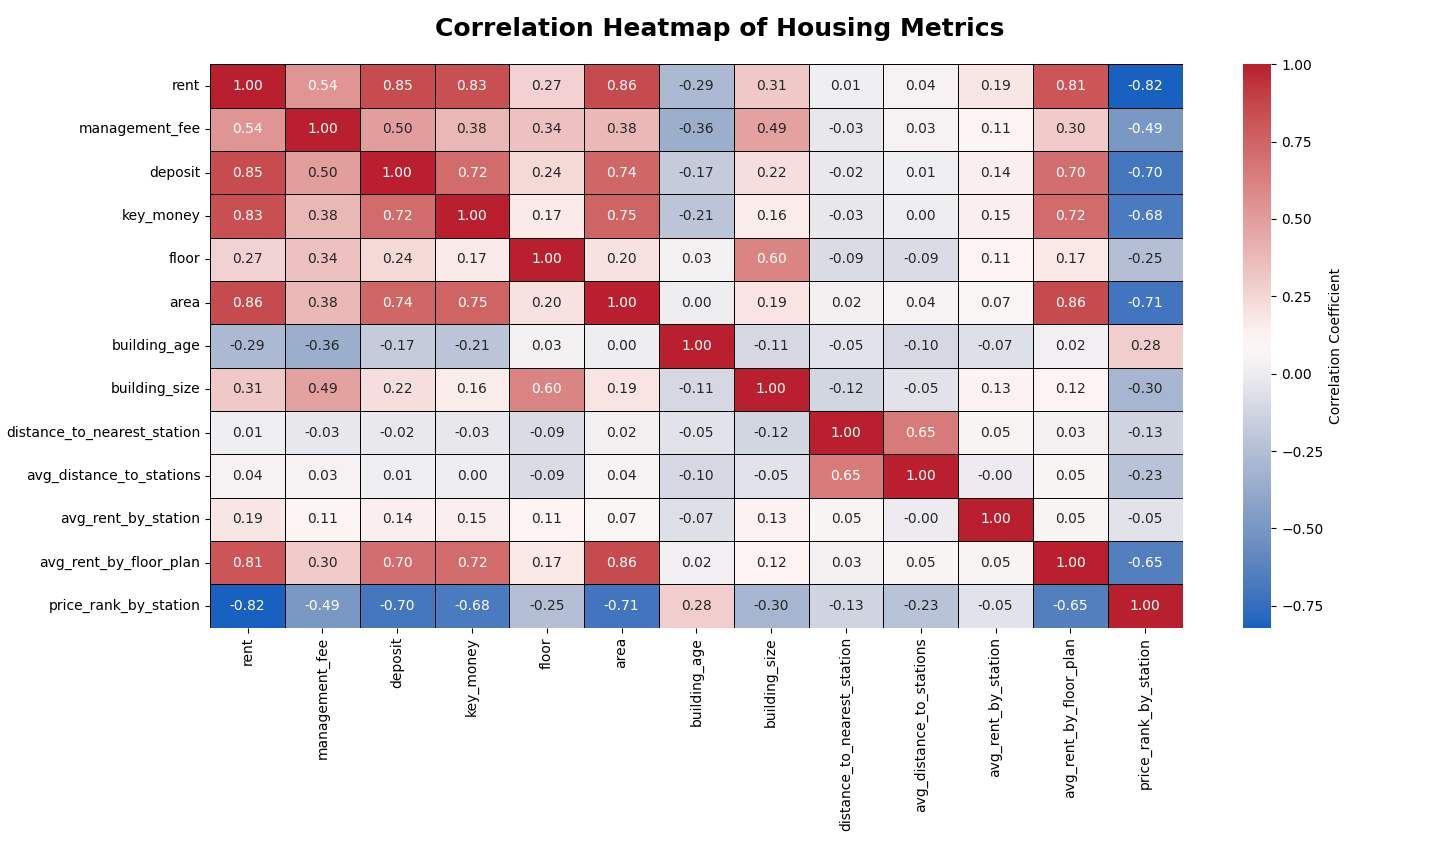

### Distribution of Rental Prices
> The following plot visualizes the **overall distribution of rental prices** across the dataset.
A **kernel density estimate (KDE)** curve is overlaid on the histogram to highlight the shape of the distribution, and the dashed line marks the **mean rental price**.

In [ ]:
# Set grid style 
sns.set_style("whitegrid")

# Set color palette 
palette = sns.color_palette("muted")

In [ ]:
mean_rent = tokyo_housing_df['rent'].mean()

fig = plt.figure(figsize = (15, 8))

sns.histplot(data = tokyo_housing_df, x = 'rent', color = palette[0], stat = 'density', alpha = 0.4)
sns.kdeplot(data = tokyo_housing_df, x = 'rent', color = palette[3], fill = True, linewidth = 1.5)

plt.axvline(x = mean_rent, color = 'black', linestyle = '--', label = 'Mean Rental Price')

plt.annotate(f'Mean Rent = ¥{mean_rent:.2f}', xy = (mean_rent, 0.00001), xytext = (mean_rent + 15000, 0.00001), arrowprops = dict(facecolor = 'black', shrink = 0.05), fontweight = 'bold')


plt.title('Distribution of Rental Prices', fontsize = 18, fontweight = 'bold')
plt.xlabel('Rent', fontsize = 12)
plt.ylabel('Density', fontsize = 12)

plt.savefig('rent_dist.png')

> **Distribution of Rental Prices**
>- The figure displays a **right-skewed distribution** of rental prices, indicating that **most rents are below the mean**. The mean is higher than the median, as it is pulled toward the upper end of the distribution by a small number of very expensive listings.
>- The **mean rental price is approximately ¥101697**. 

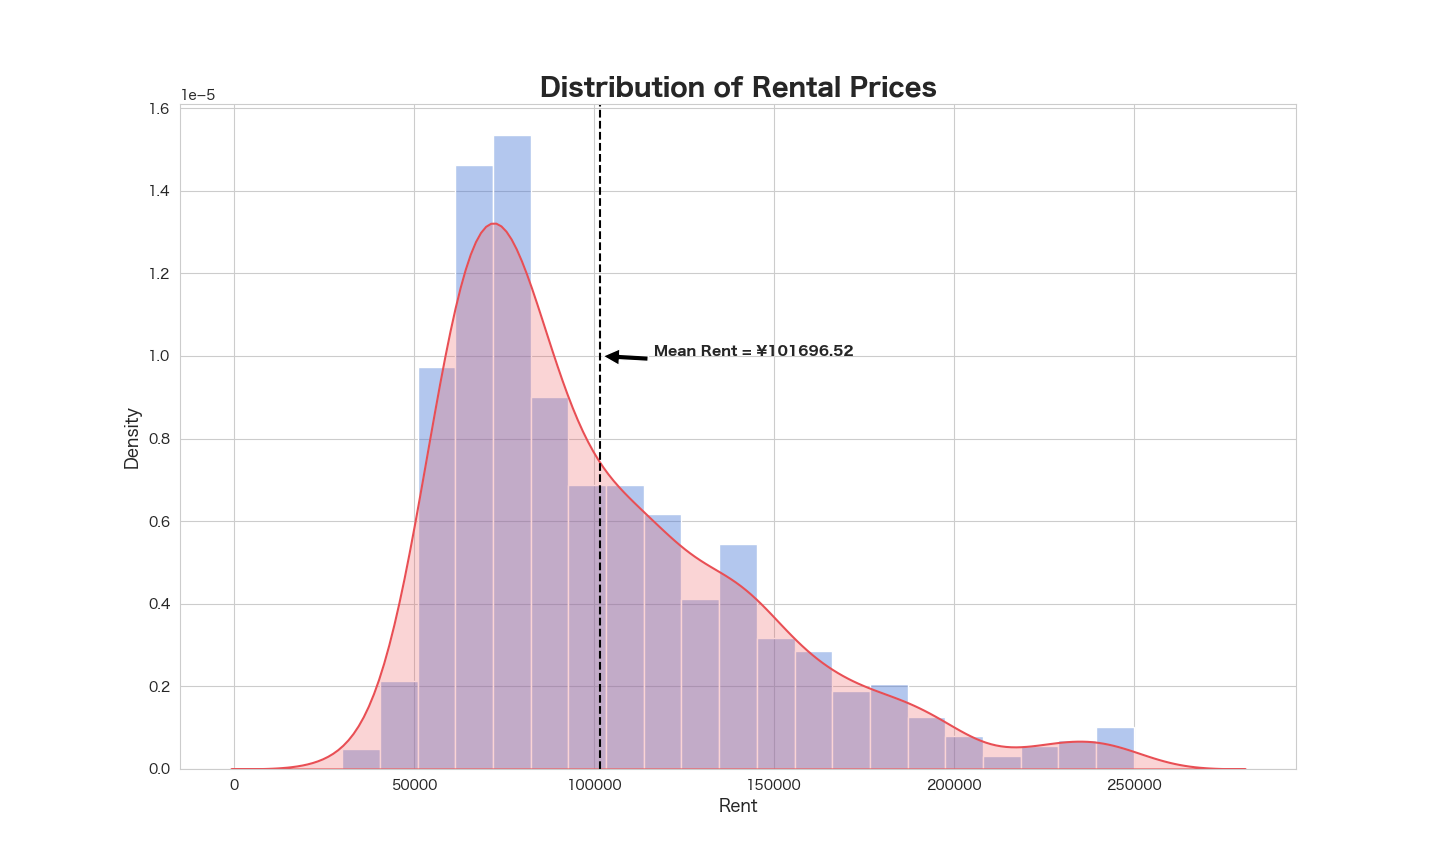

### Average Rent: Confidence Interval Analysis
>We calculate a **95% confidence interval for the mean rental price** in the Nakai area.
>- **Confidence level**: 95%
>- **Significance level**: α = 0.05
>
>The confidence interval provides a range in which we are 95% confident that the true mean rent lies.

In [69]:
# Confidence level -- 95%
# Significance level -- alpha = 0.05
alpha = 0.05

rent = tokyo_housing_df['rent']

# Compute the sample mean
x_bar = np.mean(rent)

# Compute the sample size
n = len(rent)
print(f'The sample size is {n}')

The sample size is 1207


>- Typically, when the population standard deviation is unknown, we use the **Student's t-distribution**. However, as the sample size *n* grows, the degrees of freedom increase and the **t-distribution approaches the normal (Gaussian) distribution**. With a **large sample size** of around 1,200, the **t-distribution is effectively Gaussian**, allowing us to use the **z critical value**. For a significance level of *α* = 0.05, the corresponding z critical value is 1.96.
>- The resulting **confidence interval is ¥101696.520 &plusmn; 2407.703**. In other words, we are 95% confident that the true mean rent falls within this range. 

In [70]:
# Compute the standard error (SE)
se = np.std(rent)/np.sqrt(n)

# Compute the z critical value
# Compute the margin of error (MOE)
z = norm.ppf(1 - (alpha/2))
moe = z*se 
print(f'The 95% confidence interval is {x_bar:.3f} +/- {moe:.3f}')

The 95% confidence interval is 101696.520 +/- 2407.703


### Correlation Between Rent & Floor Area
> As noted earlier, `area` exhibits the strongest correlation with `rent`. In this section, we explore the relationship between `rent` and `area` using a **scatter plot** and compute the **Pearson correlation coefficient** to quantify the strength and direction of the linear relationship. **For the following analyses, the predetermined level of significance (*α*) is 0.05**.

In [ ]:
# Pearson correlation between rent and area
pearson_coeff, p_value = stats.pearsonr(x = tokyo_housing_df['area'], y = tokyo_housing_df['rent'])

# Initialize fig, ax
fig, ax = plt.subplots(figsize = (15, 8))

# Scatter plot of rent vs. area with pearson coefficient & p-value
plt.scatter(tokyo_housing_df['area'], tokyo_housing_df['rent'], color = palette[0])
plt.text(0.10, 0.95, f'Rent & Area:\npearson_coeff = {pearson_coeff}\np_value = {p_value}', transform = ax.transAxes, verticalalignment = 'top', fontweight = 'bold')

# Set title, axis labels
plt.title('Correlation of Rent with Floor Area', fontsize = 18, fontweight = 'bold')
plt.xlabel('Area (m^2)', fontsize = 12)
plt.ylabel('Rent (¥)', fontsize = 12)

plt.savefig('rent_vs_area.png')

>**Correlation of Rent with Floor Area**
>
>- The scatter plot and Pearson correlation coefficient indicate a **strong positive relationship** between `rent` and `area`.
>- The **p-value is extremely small** (effectively zero), suggesting that the likelihood of this relationship occurring by chance is negligible. Therefore, **we can confidently reject the null hypothesis** of no correlation.
>- It’s worth noting that there is a slight presence of **heteroskedasticity** in the scatter plot. While this could potentially affect future modeling, it appears minor and will not be addressed in the current analysis.

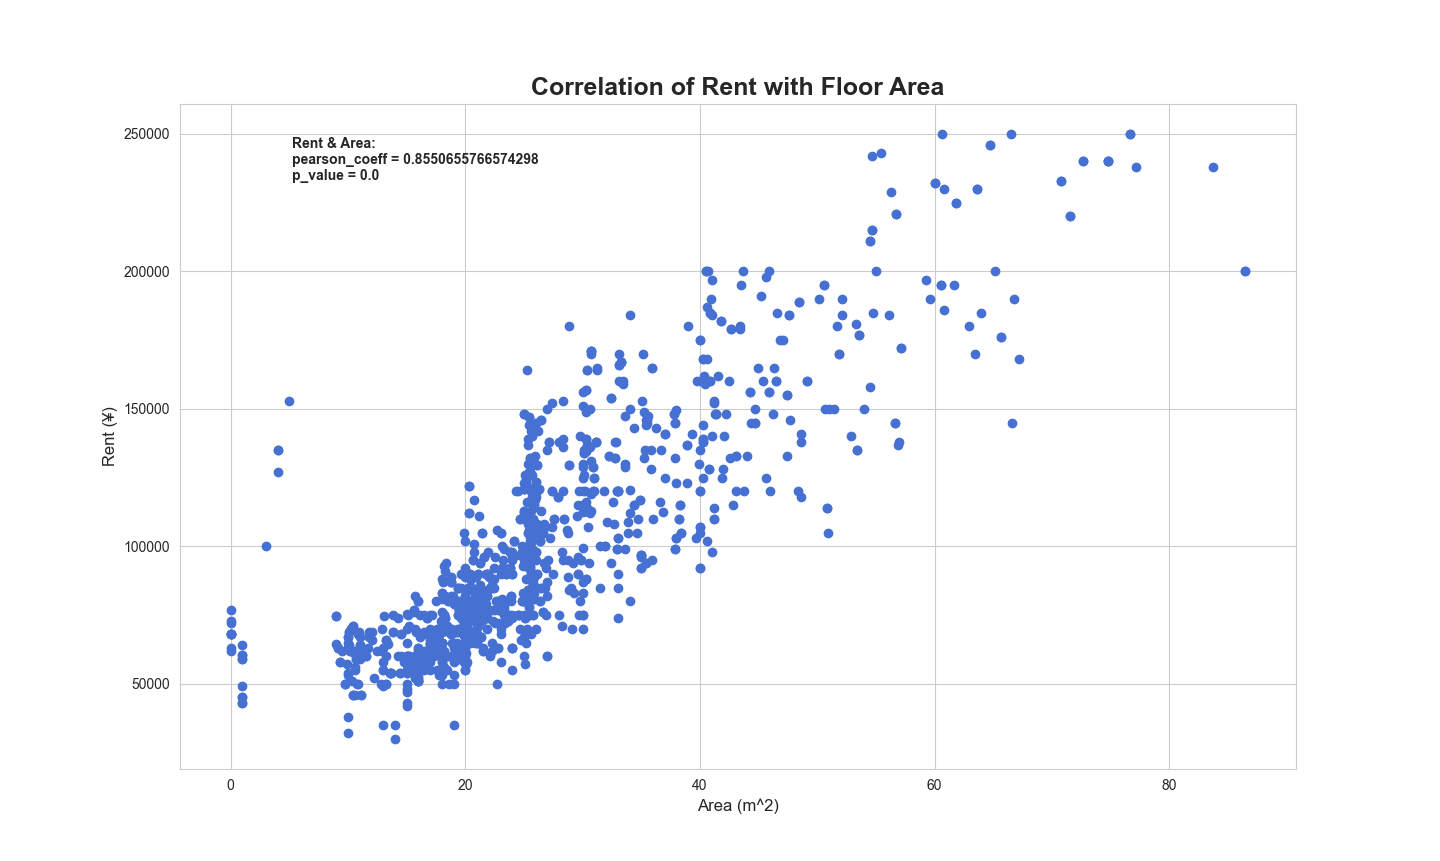

### Correlation Between Rent & Building Age
>In this section, we examine the relationship between `rent` and `building_age`, a **quantitative discrete variable**. Typically, features with a small number of unordered discrete values are best visualized using a **box plot**. However, since `building_age` has a **clear order and many distinct values**, a **scatter plot** is more appropriate for visualization. We also calculate the **Pearson correlation coefficient** to quantify the relationship between `rent` and `building_age`.

In [ ]:
# Pearson correlation between rent and area
pearson_coeff, p_value = stats.pearsonr(x = tokyo_housing_df['building_age'], y = tokyo_housing_df['rent'])

# Initialize fig, ax
fig, ax = plt.subplots(figsize = (15, 8))

# Scatter plot of rent vs. area with pearson coefficient & p-value
plt.scatter(tokyo_housing_df['building_age'], tokyo_housing_df['rent'], color = palette[1])
plt.text(0.70, 0.95, f'Rent & Building Age:\npearson_coeff = {pearson_coeff}\np_value = {p_value}', transform = ax.transAxes, verticalalignment = 'top', fontweight = 'bold')

# Set title, axis labels
plt.title('Correlation of Rent with Building Age', fontsize = 18, fontweight = 'bold')
plt.xlabel('Age (Years)', fontsize = 12)
plt.ylabel('Rent (¥)', fontsize = 12)

plt.savefig('age_vs_area.png')

>**Correlation of Rent with Building Age**
>
>- The scatter plot and Pearson correlation coefficient indicate a **moderate negative relationship** between `rent` and `building_age`.
>- The **p-value is extremely small**, suggesting that the likelihood of this relationship occurring by chance is negligible. Therefore, **we can confidently reject the null hypothesis** of no correlation.
>- It’s worth noting that the **densest cluster** of points seems to **decrease rapidly at first and then level off**, indicating a **slight non-linear trend**. However, overall, the scatter plot and Pearson correlation coefficient still suggest an **approximately linear relationship**.

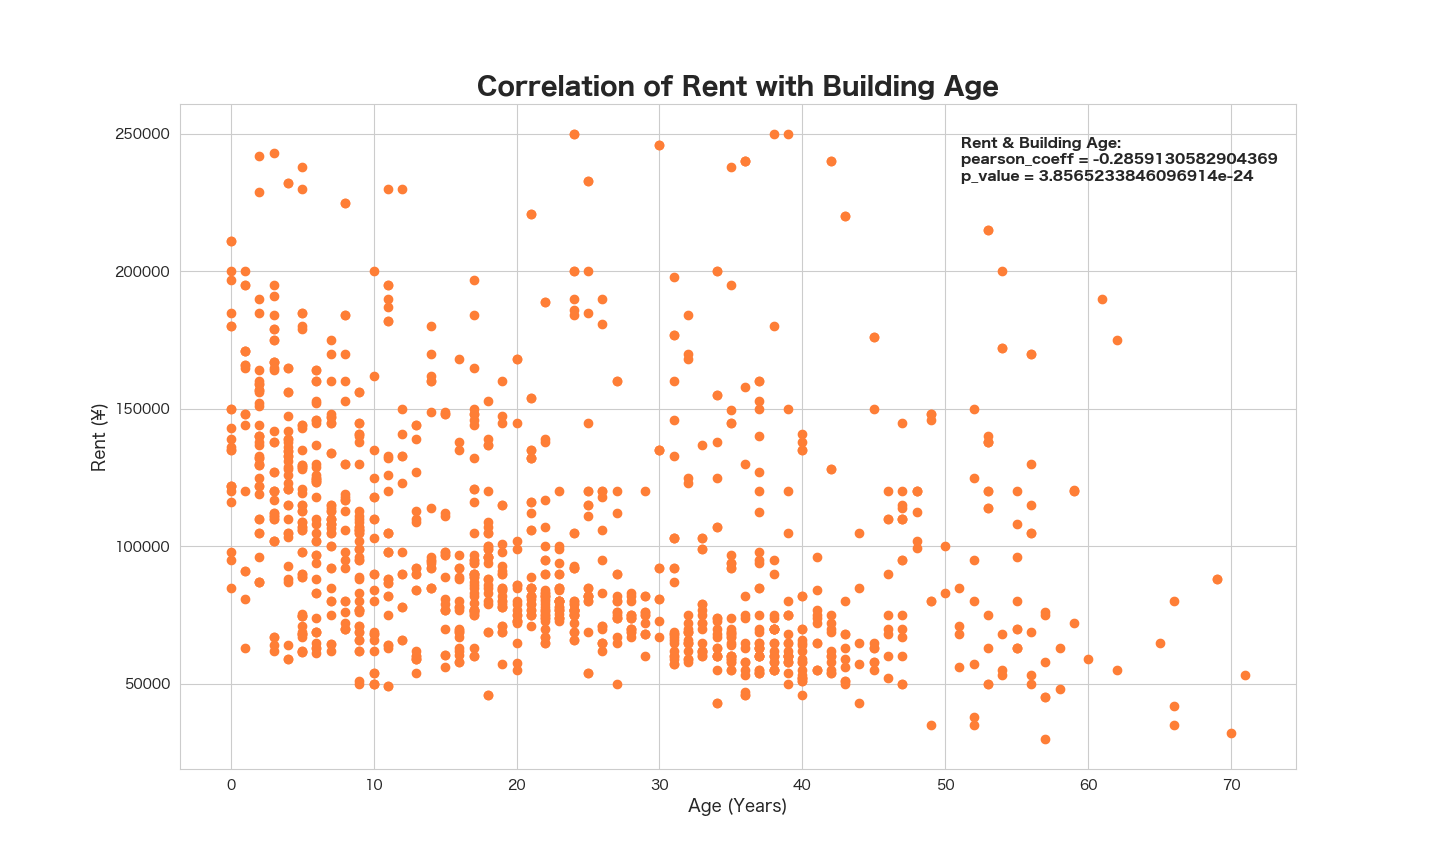

### Rent Distribution Across Floor Plans
>In this section, we explore the relationship between `rent` and `floor_plan`, a **qualitative (categorical) feature**. We use a **box plot** to visualize the different `floor_plan` categories and **corresponding price distributions**.

In [ ]:
# Initialize figure
fig = plt.figure(figsize = (15, 8))

# Boxplot distribution of rent by floor plan
sns.boxplot(data = tokyo_housing_df, x = 'floor_plan', y = 'rent', palette = palette, flierprops = {'mfc' : 'black', 'marker': 'D'})

# Set title, axis labels
plt.title('Distribution of Rent by Floor Plan', fontsize = 18, fontweight = 'bold')
plt.xlabel('Floor Plan', fontsize = 12)
plt.ylabel('Rent (¥)', fontsize = 12)

plt.savefig('floor_plan_box.png')

>**Distribution of Rent by Floor Plan**
>- The box plot shows that **larger or more complex** `floor_plan` types generally correspond to **higher rent**.
>- The **numeric values** (e.g., `1LDK`, `2SDK`, `3DK`) represent the **number of rooms** in the unit. As expected, `rent` tends to **increase with the number of rooms**.
>- The **letters** in each category (e.g., "K" for Kitchen, "L" for Living room, etc.) indicate **additional features**. Units with **more of these features** typically command **higher rental prices**.

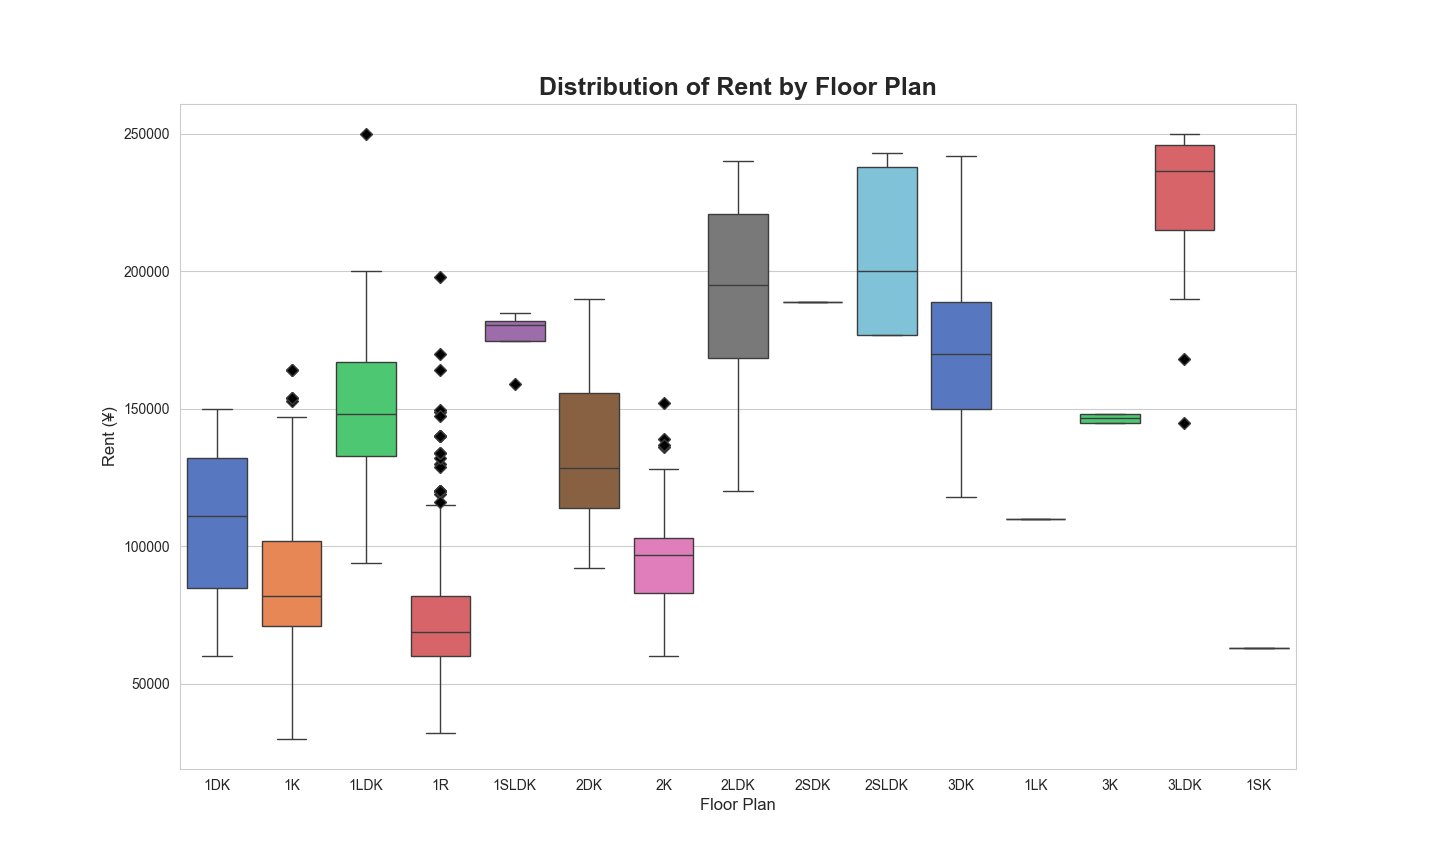

### Rent Variation with Station Proximity 
>In this section, we analyze **how proximity to the nearest station affects rental prices**. While **ordered quantitative variables** are often visualized with **scatter plots**, `distance_to_nearest_station` contains a relatively **small set of discrete values**. Therefore, a **box plot** is more appropriate here, as it clearly illustrates how rent distributions shift with increasing walking distance to the station.

In [ ]:
# Initialize figure
fig = plt.figure(figsize = (15, 8))

# Boxplot distribution of rent by distance to nearest station
sns.boxplot(data = tokyo_housing_df, x = 'distance_to_nearest_station', y = 'rent', palette = palette, flierprops = {'mfc' : 'black', 'marker': 'D'})

# Set title, axis labels
plt.title('Distribution of Rent by Station Proximity', fontsize = 18, fontweight = 'bold')
plt.xlabel('Distance to Nearest Station (min)', fontsize = 12)
plt.ylabel('Rent (¥)', fontsize = 12)

plt.savefig('distance_box.png')

>**Distribution of Rent by Station Proximity**
>- The box plot shows **no clear relationship between** `distance_to_nearest_station` **and** `rent`.
>- This result is **somewhat unexpected**, as one might assume that **units closer to train stations are more desirable** and therefore **more expensive**.
>- Interestingly, the **highest rent values** appear among properties **farthest from the station**, contradicting the initial assumption.

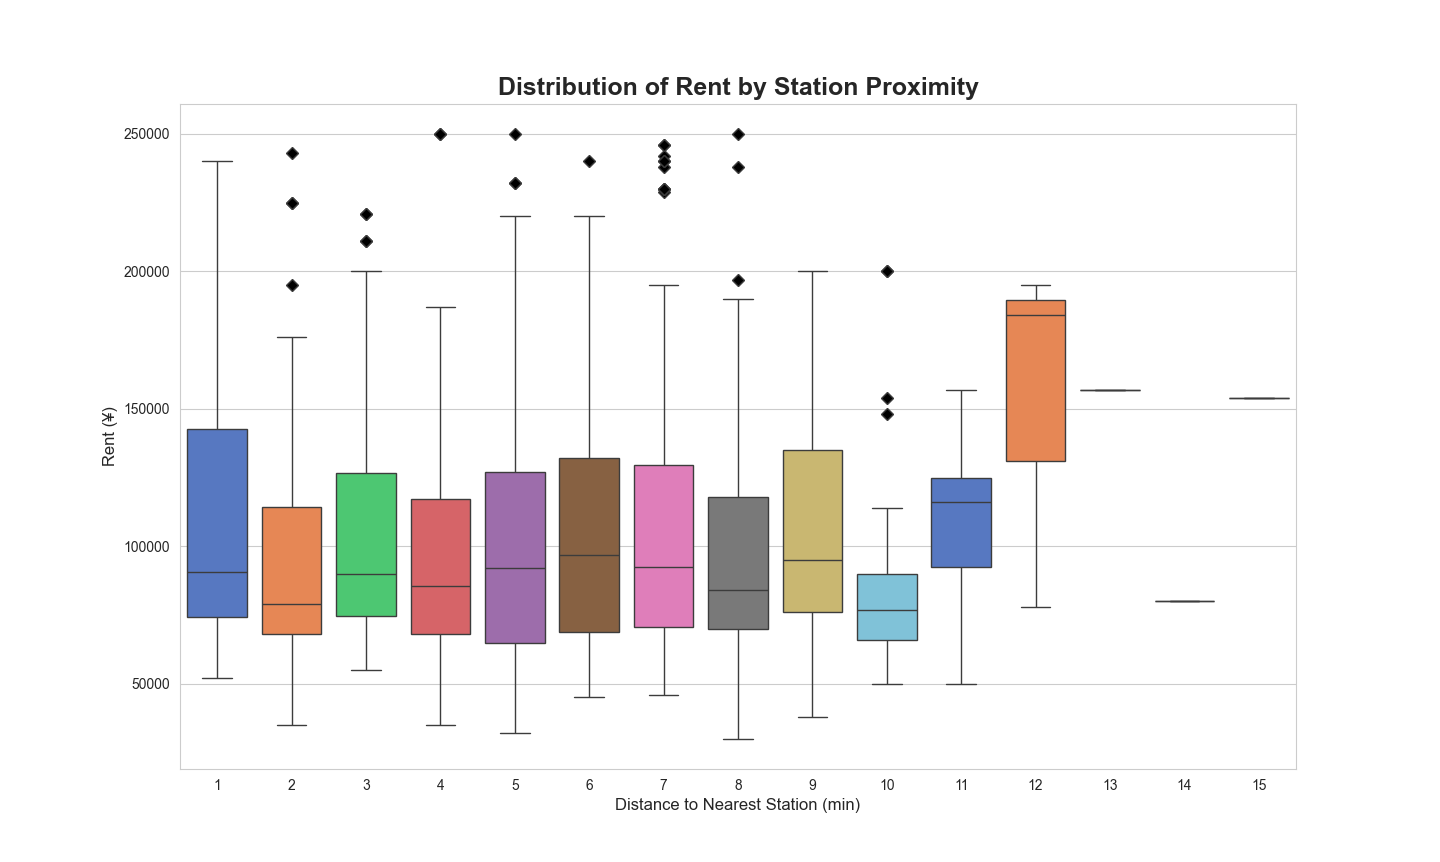

### Rent Distribution Across Stations
>In this section, we explore **how rental prices vary by station**. Since `nearest_station` is a **categorical variable**, a **box plot** is ideal for visualizing the **distribution of rent across different stations**. This allows us to identify patterns, outliers, and variations in `rent` depending on the nearest station.

In [ ]:
# Initialize figure
fig = plt.figure(figsize = (15, 8))

# Set a Japanese-capable font 
rc('font', family = 'Hiragino Sans')

# Boxplot distribution of rent by nearest station
sns.boxplot(data = tokyo_housing_df, x = 'nearest_station', y = 'rent', palette = palette, flierprops = {'mfc' : 'black', 'marker': 'D'})

# Set title, axis labels
plt.title('Distribution of Rent by Nearest Station', fontsize = 18, fontweight = 'bold')
plt.xlabel('Station', fontsize = 12)
plt.ylabel('Rent (¥)', fontsize = 12)

plt.savefig('nearest_station.png')

>**Distribution of Rent by Nearest Station**
>- The box plot shows **no obvious relationship between** `nearest_station` **and** `rent`.
>- This is not particularly surprising, as **most stations** (except major hubs with multiple lines) **do not overwhelmingly influence housing or commuting patterns**.
>- The appeal of each station varies, with **desirability depending on multiple factors** beyond proximity alone.

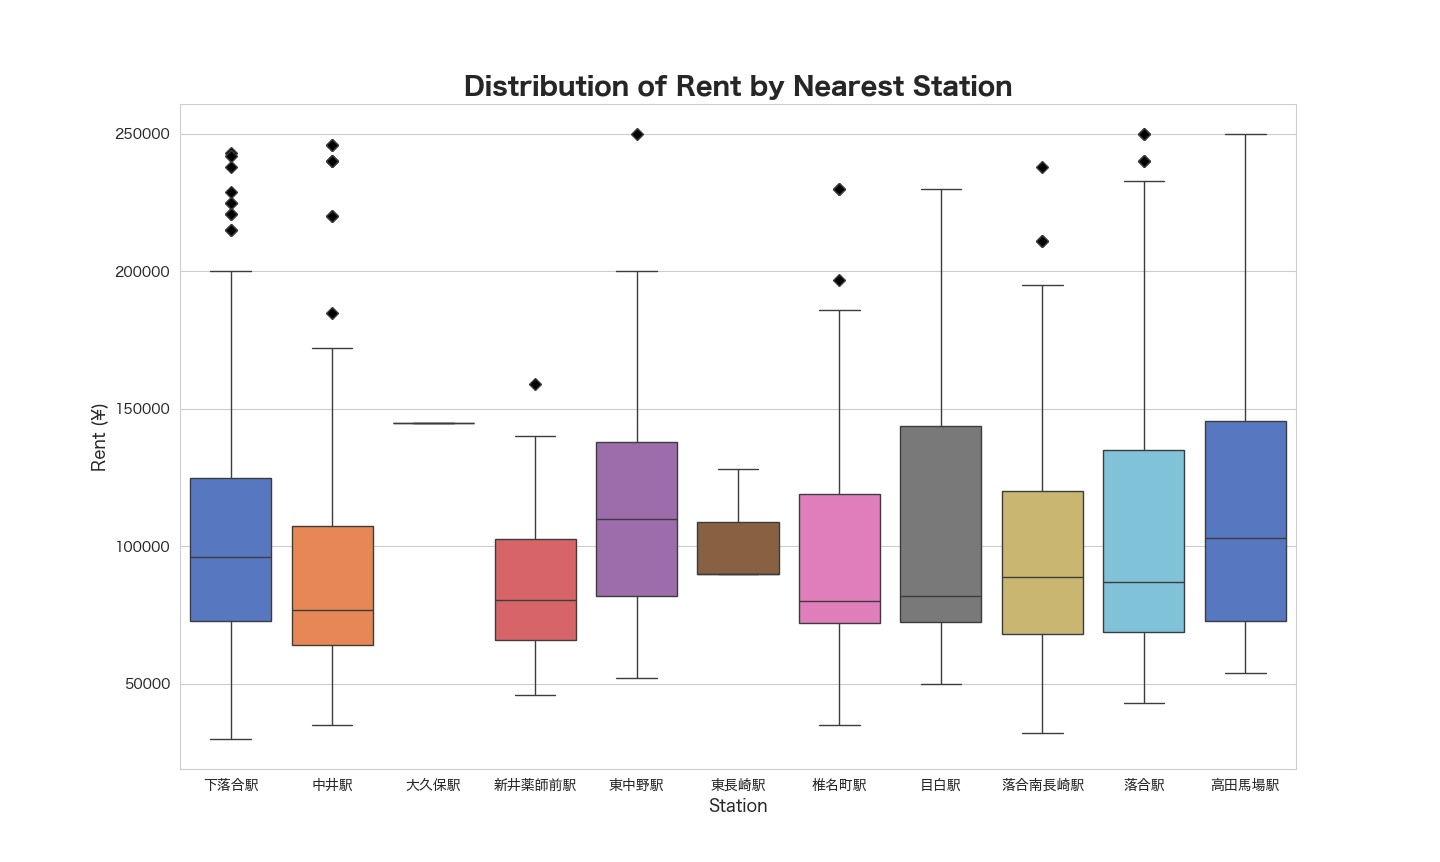

### Rent Variation with Building Size
> Like `distance_to_nearest_station`, `building_size` has a **limited number of discrete values**, making a **box plot** the most appropriate way to visualize its **relationship with** `rent`. The box plot **maintains the order of the integer values**, allowing us to see how `rent` distributions change as `building_size` increases.

In [ ]:
# Initialize figure
fig = plt.figure(figsize = (15, 8))

# Boxplot distribution of rent by building_size
sns.boxplot(data = tokyo_housing_df, x = 'building_size', y = 'rent', palette = palette, flierprops = {'mfc' : 'black', 'marker': 'D'})

# Set title, axis labels
plt.title('Distribution of Rent by Building Size', fontsize = 18, fontweight = 'bold')
plt.xlabel('Building Size (# of Floors)', fontsize = 12)
plt.ylabel('Rent (¥)', fontsize = 12)

plt.savefig('building_size_box.png')

>**Distribution of Rent by Building Size**
>- The plot shows that `rent` **tends to increase with** `building_size`.
>- The relationship between `building_age` and `rent` appears nonlinear, **resembling a third-order polynomial**: initially rising, then flattening, and rising again.
>- For the **current analysis**, we will **assume linearity**, though fitting a third-order polynomial could be explored in future analyses.

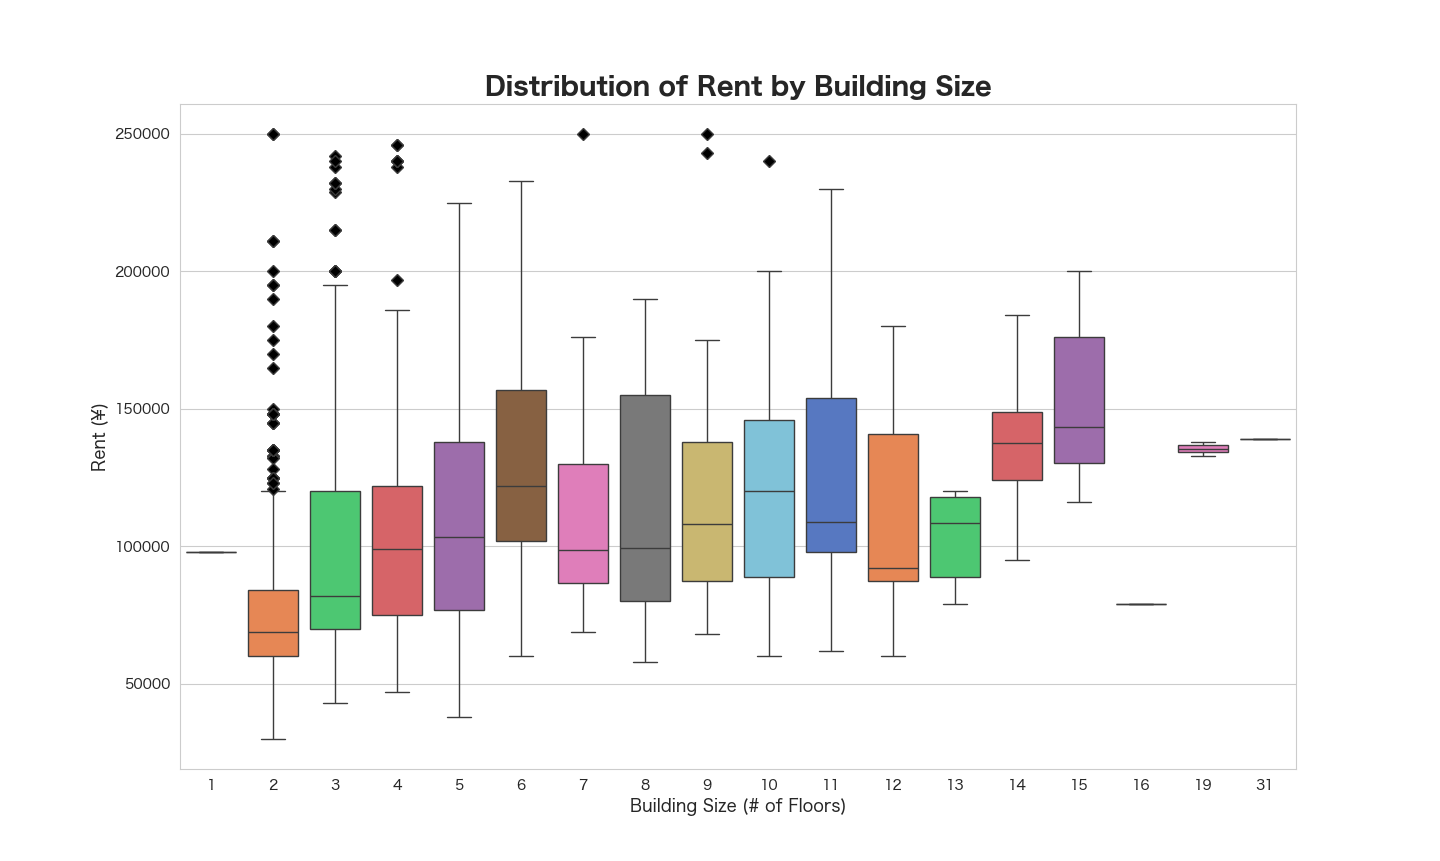

### Rent Variation Across Floor Levels
>Like `building_size`, `floor` is an **ordered quantitative variable** with only a **small set of discrete values**. For this reason, a **box plot** is the most effective way to visualize the **relationship between** `rent` **and** `floor`. It clearly highlights any patterns or shifts in the distribution of rental prices as floor levels increase. 

In [ ]:
# Initialize figure
fig = plt.figure(figsize = (15, 8))

# Boxplot distribution of rent by floor
sns.boxplot(data = tokyo_housing_df, x = 'floor', y = 'rent', palette = palette, flierprops = {'mfc' : 'black', 'marker': 'D'})

# Set title, axis labels
plt.title('Distribution of Rent by Floor', fontsize = 18, fontweight = 'bold')
plt.xlabel('Floor', fontsize = 12)
plt.ylabel('Rent (¥)', fontsize = 12)

plt.savefig('floor_box.png')

>**Distribution of Rent by Floor**
>- The box plot indicates that `rent` **generally increases with** `floor`.
>- The relationship between `floor` and `rent` appears **mostly linear**, though listings on the **ground floor** (`0`) show a noticeably **higher median rent** compared to several of the subsequent floors.
>- In short, while **higher floors** tend to yield **higher prices**, the **ground floor** still appears to be one of the **more desirable**, and therefore pricier, levels.

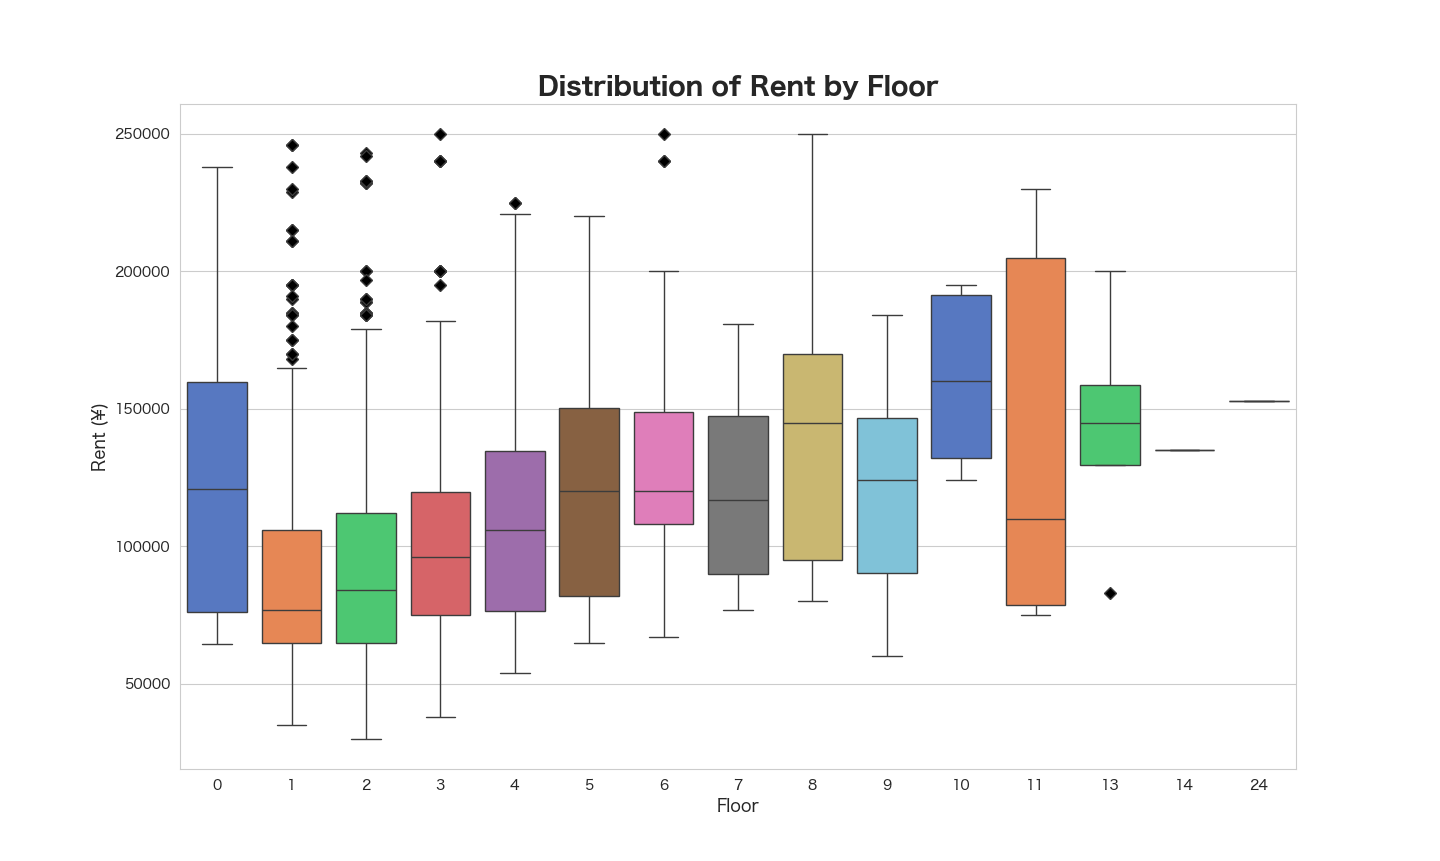

## Modeling Rent with Linear Regression

### Data Preprocessing & One-Hot Encoding 
>- The target variable (`rent`) is separated from the predictors.
>- The data is split into **training and testing sets**.
>- The categorical variable `floor_plan` is encoded using **OneHotEncoder** with `drop='first'` to **avoid multicollinearity**.
>- **Encoded columns are combined with the numeric features** (`area`, `building_age`, `building_size`, `floor`) to form the **final feature matrices** for training and testing.

In [4]:
# Define X, y for LinearRegression
X = tokyo_housing_df.drop(columns = ['rent'])
y = tokyo_housing_df['rent']

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Initialize OneHotEncoder for categorical variables (floor_plan)
# sparse_output returns a numpy array, which is easier to inspect & convert back to DataFrame
encoder = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)

# OneHotEncoder may throw a UserWarning error from 'unknown categories' -- these will be encoded as zeros
warnings.filterwarnings('ignore', category = UserWarning)

# Pass DataFrame to the encoder to preserve the column name
X_train_enc = encoder.fit_transform(X_train[['floor_plan']])
X_test_enc = encoder.transform(X_test[['floor_plan']])

# Get the encoded feature names to for columns in the DataFrame
encoded_cols = list(encoder.get_feature_names_out(['floor_plan']))

# Use the index = X_train.index parameter to ensure that the indexing matches 
X_train_enc = pd.DataFrame(X_train_enc, columns = encoded_cols, index = X_train.index)
X_test_enc = pd.DataFrame(X_test_enc, columns = encoded_cols, index = X_test.index)

# Final train/test sets include area and floor_plan encoded features
X_train = pd.concat([X_train[['area', 'building_age', 'building_size', 'floor']], X_train_enc], axis = 1)
X_test = pd.concat([X_test[['area', 'building_age', 'building_size', 'floor']], X_test_enc], axis = 1)

### Simple Linear Regression Using Area Only
>- We fit a **simple linear regression model** using only `area` to predict `rent`.
>- This serves as a **baseline model**, since `area` shows the **strongest linear relationship** with `rent` by a wide margin.
>- We evaluate performance using **5-fold cross-validation**, providing a benchmark for the predictive power of the single-feature model.
>- On average, the **model explains about 71.8% of the variance** ($R^2$) in `rent` across the 5-fold splits.

In [5]:
# Initialize model 
lr0 = LinearRegression()

# Simple Linear Regression
X_train_0 = X_train[['area']]

# Compute scores for 5-fold cross validation on training dataset
score_0 = cross_val_score(lr0, X_train_0, y_train, cv = 5).mean()
print(f'The average of the R-squared values is {score_0: .3f}')

The average of the R-squared values is  0.718


### Multiple Linear Regression Model
>- We expand to a full **multivariate model** using all available numeric and encoded features.
>- Before fitting, we standardize the predictors with **StandardScaler** to ensure that **all variables are on comparable scales**.
>- **Cross-validation** again provides an estimate of the **model’s general performance**.
>- Averaged over the 5-fold splits, the **model achieves an $R^2$ of about 84.9%** for `rent`, significantly outperforming the single-feature model.

In [6]:
# Initialize model                            
lr1 = LinearRegression()

# Initialize scaler object & standardize data for regression
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Multiple Linear Regression
score_1 = cross_val_score(lr1, X_train_scaled, y_train, cv = 5).mean()
print(f'The average of the R-squared values is {score_1: .3f}')

The average of the R-squared values is  0.849


### Model Fitting & Performance Evaluation
>- We train a **LinearRegression** model on the scaled training data and **generate predictions for both training and testing sets**.
>- Performance is evaluated using **R-squared**, allowing us to compare model fit on seen vs. unseen data and **check for overfitting**.
>- The model attains an **$R^2$** of approximately **85.9% on the training set** and about **86.8% on the testing set**.
>- While it is somewhat unusual for the model to **perform slightly better on the testing set** than on the training set, the **difference is minor** and could easily be due to **how the data was split**.

In [7]:
# Initialize Linear Regression model & fit to the training data
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Make predictions on training and testing sets
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

# Evaluate on training set
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared value the training set: {r2_train: .3f}')

# Evaluate on testing set
r2_test = r2_score(y_test, y_test_pred)
print(f'R-squared value on the testing set: {r2_test: .3f}')

R-squared value the training set:  0.859
R-squared value on the testing set:  0.868


### Residual Analysis & Diagnostics
>In this section, a **scatter plot** is used to visualize the residuals—the **differences between predicted and actual** `rent` values on the **testing set**. This helps identify **nonlinearity**, **heteroscedasticity**, or **other patterns** the linear model may not be capturing.

In [ ]:
# Compute residuals
y_resid = y_test_pred - y_test

# Initialize fig, ax
fig, ax = plt.subplots(figsize = (15, 8))

# Scatter plot for residuals
ax.scatter(x = y_test_pred, y = y_resid, color = palette[0])

# Set title, axis labels
ax.set_title('Residual Plot of Predicted vs. Actual Values', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Predicted Rent (¥)', fontsize = 12)
ax.set_ylabel('Residuals (Predicted – Actual)', fontsize = 12)

plt.savefig('residuals.png')

> **Residual Plot of Predicted vs. Actual Values**
>- The residuals appear to be **fairly evenly distributed** around the x-axis.
>- **No clear nonlinear patterns** (e.g., quadratic curvature) are visible in the plot.
>- Although there might seem to be **slight heteroscedasticity** at first glance, the effect is likely due to **denser clustering of points** at lower `rent` values.

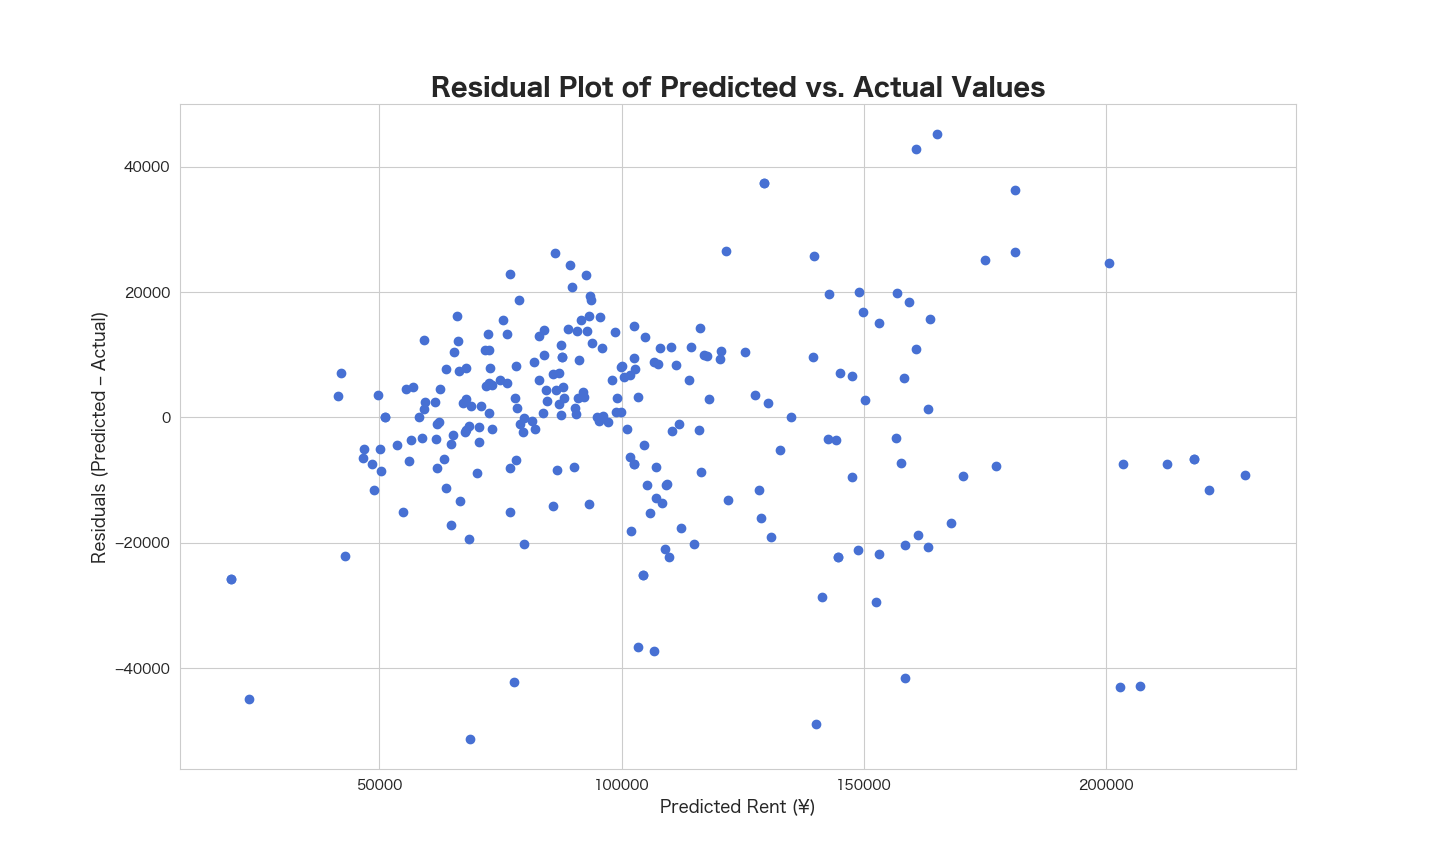

### Predicted vs. Actual Rent Distributions
>Finally, we compare the **probability density distributions** of predicted and actual `rent` values using a **histogram** with **KDE overlays**. This allows us to see how closely the **model's predictions** align with the **true price** distribution, offering a more robust evaluation of **model performance**.

In [ ]:
# Initialize fig, ax
fig, ax = plt.subplots(figsize = (15, 8))

# Histogram + KDE plots for predicted vs. actual rent values
sns.histplot(y_test_pred, palette = palette[1], kde = True, ax = ax, stat = 'density', alpha = 0.4)
sns.histplot(y_test, palette = palette[2], kde = True, ax = ax, stat = 'density', alpha = 0.4)

# Set title, axis labels
ax.set_title('Probability Density of Predicted vs. Actual Values', fontweight = 'bold', fontsize = 18)
ax.set_xlabel('Rent (¥)', fontsize = 12)
ax.set_ylabel('Density', fontsize = 12)

# Set legend
plt.legend(['Predicted Values', 'Actual Values'])

plt.savefig('predicted_vs_actual.png')

>**Probability Density of Predicted vs. Actual Values**
>- The predicted values closely follow the shape of the actual `rent` distribution, indicating that the **model captures the overall distribution fairly well**.
>- The **median** of the **predicted KDE** is slightly to the **right of the actual median**, showing a tendency to **overpredict rents**.
>- **Oscillations** between predicted and actual values in the **higher** `rent` **range** highlight **limitations** in the model’s ability to accurately **capture the tails**.
>- These **limitations** likely arise from a combination of factors, such as **fewer high-rent observations**, potential **nonlinearity** in the data, or **missing relevant features** in the model.

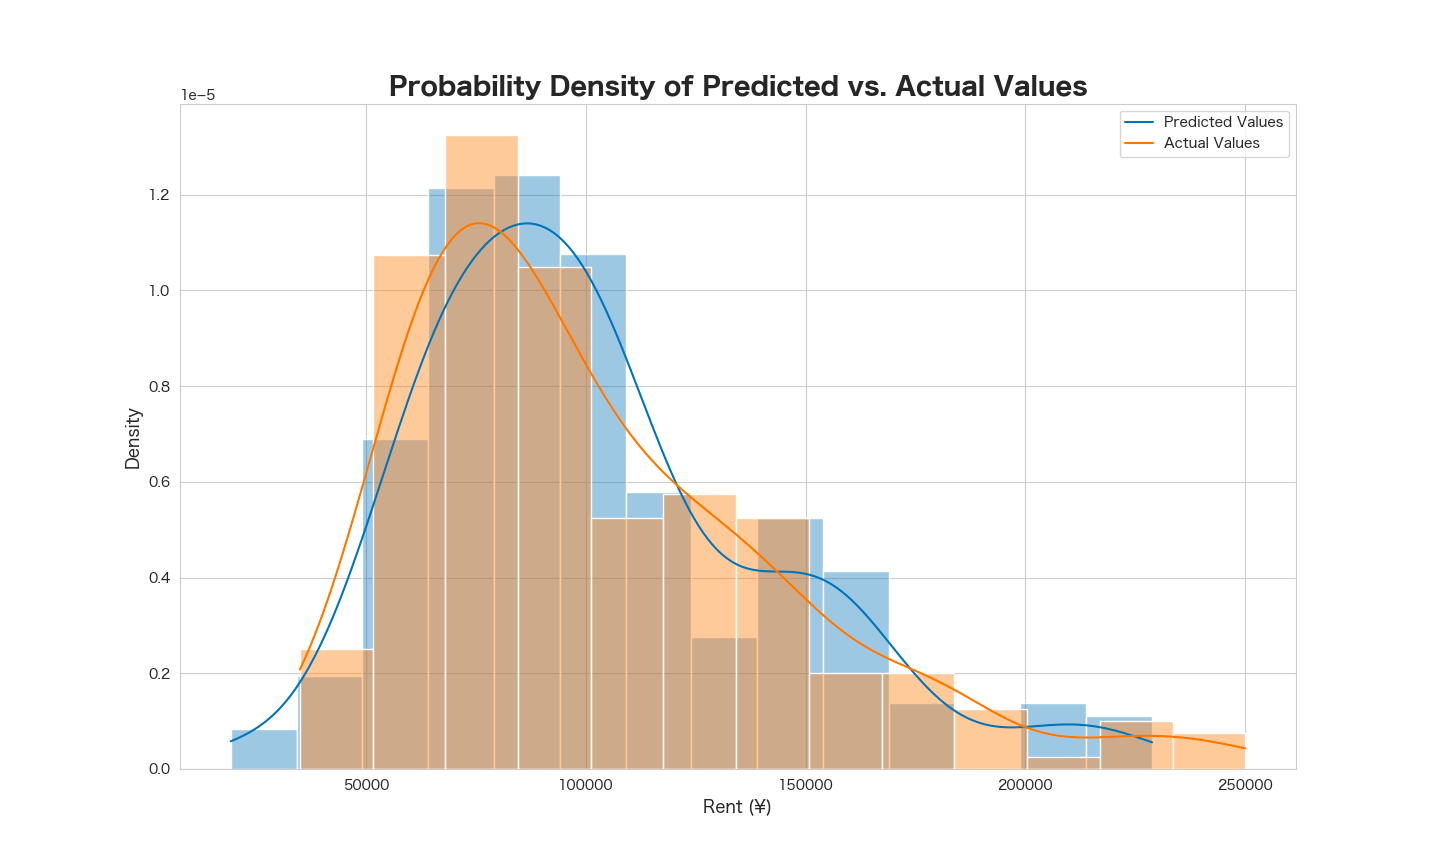

## Export Final Metrics Table
> 1. **Export DataFrame to CSV**: Save the cleaned and processed DataFrame to a CSV file without including the index.
> 2. **Preview the Final Table**: Display the first ten rows of the DataFrame.

In [4]:
# Save DataFrame to CSV file
tokyo_housing_df.to_csv('tokyo_housing.csv', index = False)

# View the final table
tokyo_housing_df.head(10)

,img,title,address,rent,management_fee,deposit,key_money,floor,floor_plan,area,building_age,building_size,nearest_station,distance_to_nearest_station,avg_distance_to_stations,avg_rent_by_station,avg_rent_by_floor_plan,price_rank_by_station
0,https://img01.suumo.com/front/gazo/fr/bukken/8...,ＺＯＯＭ高田馬場,東京都新宿区下落合１,131000.0,8000.0,131000.0,131000.0,6,1DK,30.69,4,10,下落合駅,5,7.67,106420.47,108070.42,32
1,https://img01.suumo.com/front/gazo/fr/bukken/8...,西武新宿線 下落合駅 地下1地上3階建 築6年,東京都新宿区下落合４,126000.0,10000.0,NaN,NaN,3,1DK,30.10,6,4,下落合駅,3,10.67,106420.47,108070.42,36
2,https://img01.suumo.com/front/gazo/fr/bukken/9...,リヴィコート下落合,東京都新宿区下落合１,120000.0,10000.0,120000.0,NaN,5,1DK,25.59,3,6,下落合駅,1,9.67,106420.47,108070.42,41
3,https://img01.suumo.com/front/gazo/fr/bukken/3...,西武新宿線 下落合駅 6階建 築3年,東京都新宿区下落合１,120000.0,10000.0,120000.0,NaN,5,1DK,25.59,3,6,下落合駅,1,8.67,106420.47,108070.42,41
4,https://img01.suumo.com/front/gazo/fr/bukken/8...,グランメール落合,東京都新宿区上落合１,99000.0,8000.0,99000.0,99000.0,3,1DK,32.94,33,6,下落合駅,4,6.67,106420.47,108070.42,55
5,https://img01.suumo.com/front/gazo/fr/bukken/5...,西武新宿線 下落合駅 地下1地上6階建 築33年,東京都新宿区上落合１,99000.0,8000.0,99000.0,99000.0,3,1DK,32.94,33,7,下落合駅,4,6.67,106420.47,108070.42,55
6,https://img01.suumo.com/front/gazo/fr/bukken/6...,西武新宿線 下落合駅 4階建 築59年,東京都新宿区中落合１,72000.0,3000.0,NaN,NaN,2,1DK,23.23,59,4,下落合駅,2,10.67,106420.47,108070.42,81
7,https://img01.suumo.com/front/gazo/fr/bukken/6...,マンション小滝橋,東京都新宿区高田馬場３,71000.0,9000.0,71000.0,71000.0,4,1DK,28.28,51,7,下落合駅,8,10.50,106420.47,108070.42,82
8,https://img01.suumo.com/front/gazo/fr/bukken/6...,落合エイコーマンション,東京都新宿区下落合１,67000.0,3000.0,67000.0,67000.0,6,1DK,25.00,47,6,下落合駅,4,6.00,106420.47,108070.42,85
9,https://img01.suumo.com/front/gazo/fr/bukken/9...,リリエンベルグ目白壱番館,東京都新宿区下落合３,154000.0,12000.0,NaN,NaN,2,1K,32.40,21,11,下落合駅,15,15.00,106420.47,87425.19,22


## Key Insights & Recommendations
> **1. Distribution of Rental Prices**
>- Rental prices show a **right-skewed distribution**, with an average rent of approximately **¥101,697**.
>- The **95% confidence interval** indicates that the **true mean rent** is likely within **¥101,696.520 ± 2,407.703**.
>- For staff searching for housing, this range provides a useful baseline for estimating expected rental costs.
>
> **2. Relationships Between Rent & Other Features**
>- Floor Area: The Pearson correlation coefficient (~0.855) with a near-zero p-value indicates a **strong positive relationship** between `area` and `rent`.
>- Building Age: The negative correlation coefficient (~-0.286) paired with a very small p-value suggests a **moderate inverse relationship**. In other words, **newer buildings tend to be more expensive**.
>- Floor Plan: **More complex or larger** `floor_plan` categories generally correspond to **higher rental prices**, which aligns with the increase in usable space (`area`).
>- Station Proximity: Contrary to expectations, `distance_to_nearest_station` **does not appear to meaningfully affect** `rent`.
>- Nearest Station: Similarly, **no clear relationship exists** between `nearest_station` and `rent`, suggesting that most stations offer **comparable rates** in this dataset.
>- Building Size: **Rental prices tend to increase as** `building_size` **increases**, potentially following a nonlinear (polynomial-like) trend.
>- Floor Level: Although the **ground floor** is generally among the **more expensive levels**, `rent` **increases with** `floor` in a fairly linear manner.
>- Understanding how rent relates to various housing features provides staff with meaningful context about which factors significantly influence pricing and which have minimal impact. This insight can help incoming field workers evaluate their housing preferences, prioritize features, and form realistic expectations about how specific amenities or characteristics may affect availability and cost. 
>
> **3. Rental Price Prediction**
>- We built a **multivariate linear regression model** to predict `rent` using the **most influential features**: `area`, `building_age`, `building_size`, `floor`, and `floor_plan`.
>- The model achieved an $R^2$ of approximately **85.9% on the training set** and **86.8% on the testing set**, meaning it explains roughly 86% of the variation in rental prices and is therefore a **strong overall performance**.
>- This model provides a practical tool for estimating rental costs based on key housing characteristics, supporting more informed budgeting and housing decisions for current and future staff.

## Limitations & Future Directions 
> **1. Incomplete Coverage of the Full Housing Dataset**
> 
> During web scraping from *SUUMO.jp*, many buildings contained multiple available units with different features (e.g., floor plan, floor level, and area). For simplicity, only the first unit under each listing was collected. This caused a large portion of available rental units (potentially a few hundred) to be excluded. Since lower-priced units tend to appear first in listings, this likely resulted in the observed right-skew of the rental distribution and may have biased both the confidence interval and model performance. To improve future analyses, we recommend enhancing the scraper to capture all unit-level listings for each building. This would produce a more accurate representation of rental prices and yield a more reliable confidence interval and predictive model.
> 
> **2. Continuously Changing Market Data**
> 
> Because *SUUMO.jp* updates rental listings frequently, our dataset represents only a single snapshot in time. We scraped the site once, stored the data in SQLite, and performed all analysis on the static dataset. To better reflect real market behavior, future iterations should incorporate an automated, recurring scraping process (e.g., daily or weekly) to capture new listings and pricing changes over time. This expanded dataset would not only improve model performance but also provide more meaningful insights into housing availability, pricing trends, and market volatility.
> 
> **3. Nonlinear Relationships Among Features**
> 
> Visualizing the relationships between rent and other key features revealed some nonlinear patterns. For simplicity, our current model assumes linearity. While the resulting $R^2$ indicates strong predictive performance, future analyses could benefit from applying polynomial transformations (e.g., using PolynomialFeatures in scikit-learn) to better capture these nonlinear effects. Incorporating polynomial features has the potential to improve model accuracy, but it also increases the risk of overfitting. In such cases, regularization is recommended to ensure the model generalizes well to unseen data.

## Conclusion
> Conlusion.